## MNIST with LeeNet

In [2]:
import torch
import random
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import pad

In [3]:
def fix_seed():
    random.seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.determenistic=True
    return True

fix_seed()

True

In [6]:
import torchvision.datasets as data

In [7]:
train_data=data.MNIST('./', download=True, train=True)
test_data=data.MNIST('./', download=True, train=False)

X_train, X_test=train_data.train_data.float(), test_data.test_data.float()
y_train, y_test=train_data.targets, test_data.targets

/Users/macbook/miniconda3/envs/torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/macbook/miniconda3/envs/torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [9]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

## Define  Architecture of NeuralNet 

In [16]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv_1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2
        )
        self.activ_1 = torch.nn.Tanh()
        self.pool_1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv_2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0
        )
        self.activ_2 = torch.nn.Tanh()
        self.pool_2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fully_conn_1 = torch.nn.Linear(5*5*16, 120)
        self.activ_3 = torch.nn.Tanh()
        
        self.fully_conn_2 = torch.nn.Linear(120, 84)
        self.activ_4 = torch.nn.Tanh()
        
        self.fully_conn_3 = torch.nn.Linear(84, 10)
        
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.activ_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.activ_2(x)
        x = self.pool_2(x)
        
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
        
        x = self.fully_conn_1(x)
        x = self.activ_3(x)
        x = self.fully_conn_2(x)
        x = self.activ_4(x)
        x = self.fully_conn_3(x)
        return x

In [20]:
lenet5 = LeNet5()

In [21]:
lenet5

LeNet5(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activ_1): Tanh()
  (pool_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (activ_2): Tanh()
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fully_conn_1): Linear(in_features=400, out_features=120, bias=True)
  (activ_3): Tanh()
  (fully_conn_2): Linear(in_features=120, out_features=84, bias=True)
  (activ_4): Tanh()
  (fully_conn_3): Linear(in_features=84, out_features=10, bias=True)
)

In [44]:
# ### Test with Paddings
# import torch

# N = 4
# C = 3
# C_out = 10
# H = 8
# W = 16

# x = torch.ones((N, C, H, W))

# # torch.Size([4, 10, 8, 16])
# out1 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=1)(x)
# print(out1.shape) # для самопроверки

# # torch.Size([4, 10, 8, 16])
# out2 = torch.nn.Conv2d(C, C_out, kernel_size=(5, 5), padding=2)(x)
# print(out2.shape) # для самопроверки

# # torch.Size([4, 10, 8, 16])
# out3 = torch.nn.Conv2d(C, C_out, kernel_size=(7, 7), padding=3)(x)
# print(out3.shape) # для самопроверки

# # torch.Size([4, 10, 8, 16])
# out4 = torch.nn.Conv2d(C, C_out, kernel_size=(9, 9), padding=4)(x)
# print(out4.shape) # для самопроверки

# # torch.Size([4, 10, 8, 16])
# out5 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 5), padding=(1,2))(x)
# print(out5.shape) # для самопроверки

# # torch.Size([4, 10, 22, 30])
# out6 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=(8,8))(x)
# print(out6.shape) # для самопроверки

# # torch.Size([4, 10, 7, 15])
# out7 = torch.nn.Conv2d(C, C_out, kernel_size=(4, 4), padding=1)(x)
# print(out7.shape) # для самопроверки

# # torch.Size([4, 10, 9, 17])
# out8 = torch.nn.Conv2d(C, C_out, kernel_size=(2, 2), padding=1)(x)
# print(out8.shape) # для самопроверки

In [23]:
#Define Loss and Optimizer
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [48]:
#Process of fitting on batches

batch_size = 100
test_accuracy_history = []
test_loss_history = []

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = lenet5.forward(X_batch)
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_predicts = lenet5.forward(X_test)
    test_loss_history.append(loss(test_predicts, y_test).data)
    
    accuracy = (test_predicts.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9895)
tensor(0.9877)
tensor(0.9871)
tensor(0.9888)
tensor(0.9882)
tensor(0.9882)
tensor(0.9876)
tensor(0.9885)
tensor(0.9895)
tensor(0.9851)
tensor(0.9880)


KeyboardInterrupt: 

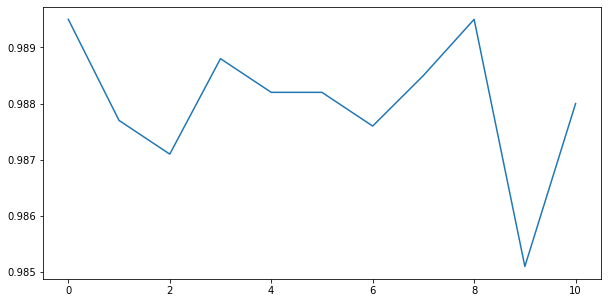

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(test_accuracy_history);

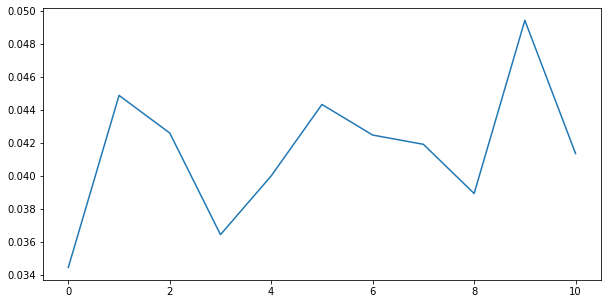

In [53]:
plt.figure(figsize=(10,5))
plt.plot(test_loss_history);